In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from graph.structure import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.prior.support_prior import SupportPrior
from graph.measurement.amplitude_measurement import AmplitudeMeasurement
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from core.linalg_utils import circular_aperture

In [3]:
# パラメータ設定
shape = (64, 64)
support = circular_aperture(shape, radius=0.25)
rng = np.random.default_rng(42)

In [4]:
# グラフ定義
class MultiplyTestGraph(Graph):
    def __init__(self):
        super().__init__()
        X = ~GaussianPrior(var = 1.0, shape = shape, label="X")
        Y = ~GaussianPrior(var = 1.0, shape = shape, label="Y")
        Z = X * Y 
        with self.observe():
            meas = AmplitudeMeasurement(var=1e-3) @ (FFT2DPropagator() @ Z)
        self.compile()

In [5]:
g = MultiplyTestGraph()

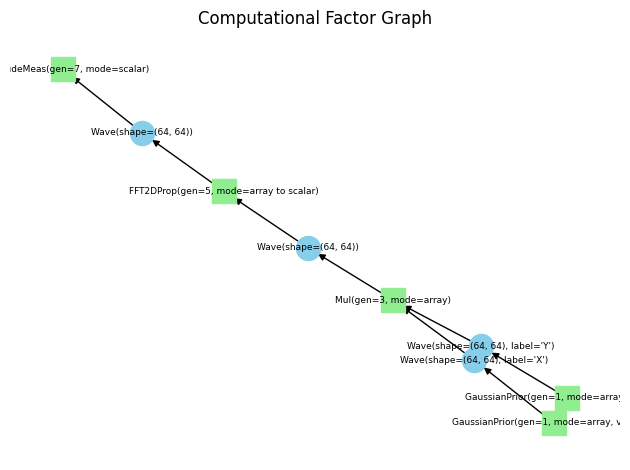

In [6]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

BP Iteration: 100%|██████████| 10/10 [00:00<00:00, 860.65it/s]


[t=0] PMSE = 1.42229e+00
[t=1] PMSE = 8.82863e-03
[t=2] PMSE = 2.63388e-04
[t=3] PMSE = 1.59251e-04
[t=4] PMSE = 1.58843e-04
[t=5] PMSE = 1.58838e-04
[t=6] PMSE = 1.58838e-04
[t=7] PMSE = 1.58838e-04
[t=8] PMSE = 1.58838e-04
[t=9] PMSE = 1.58838e-04


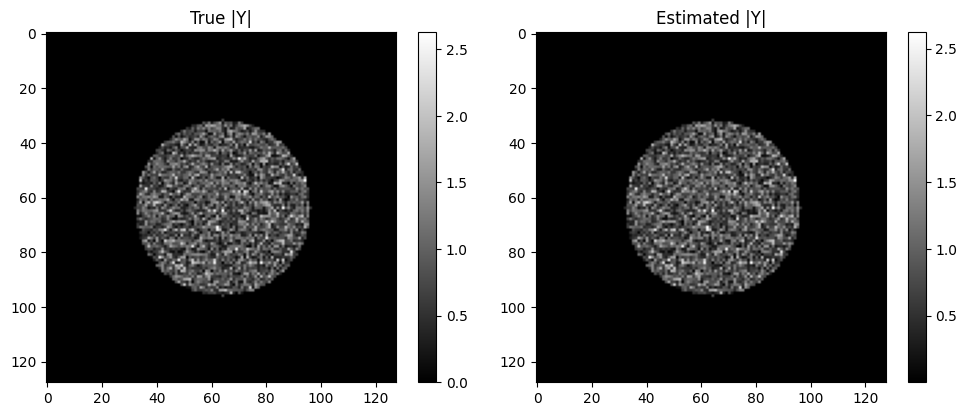

In [7]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt

from core.linalg_utils import random_normal_array, circular_aperture
from core.metrics import pmse
from graph.structure.graph import Graph
from graph.prior.const_wave import ConstWave
from graph.prior.support_prior import SupportPrior
from graph.measurement.gaussian_measurement import GaussianMeasurement
from graph.propagator.multiply_propagator import MultiplyPropagator

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
large_value = 1e6
rng = np.random.default_rng(42)

# Known input X
x_ref = random_normal_array(shape, dtype=np.complex128, rng=rng)

# Support for unknown Y
support = circular_aperture(shape, radius=0.25)

# ==== 2. グラフ定義 ====
class MultiplyGraph(Graph):
    def __init__(self):
        super().__init__()
        X = ~ConstWave(data=x_ref, large_value=large_value, label="X_ref")
        Y = ~SupportPrior(support=support, label="Y_unknown")
        Z = X * Y  # MultiplyPropagator via __mul__
        with self.observe():
            meas = GaussianMeasurement(var=var) @ Z
        self.compile()

# ==== 3. 初期化と推論 ====
g = MultiplyGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=123), update_observed=True)

true_y = g.get_wave("Y_unknown").get_sample()

def monitor(graph, t):
    est = graph.get_wave("Y_unknown").compute_belief().data
    err = pmse(est, true_y)
    print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=10, callback=monitor)

# ==== 4. 可視化 ====
est = g.get_wave("Y_unknown").compute_belief().data

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("True |Y|")
plt.imshow(np.abs(true_y), cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Estimated |Y|")
plt.imshow(np.abs(est), cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

In [8]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt

from core.metrics import pmse
from core.linalg_utils import random_normal_array, circular_aperture, random_phase_mask
from graph.structure.graph import Graph
from graph.prior.const_wave import ConstWave
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.propagator.add_propagator import AddPropagator
from graph.propagator.multiply_propagator import MultiplyPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
rng = np.random.default_rng(123)
x = random_normal_array(shape, rng=rng)
y = random_normal_array(shape, rng=rng)
z = random_normal_array(shape, rng=rng)

# ==== 2. グラフ定義 ====
class MixedMeasurementGraph(Graph):
    def __init__(self):
        super().__init__()
        X = ~ConstWave(data=x, label="X")
        Y = ~ConstWave(data=y, label="Y")
        Z = ~ConstWave(data=z, label="Z")
        W = ~GaussianPrior(shape=shape, var=1.0, label="W_unknown")

        # Define paths
        A1 = X * W
        A2 = Y * W
        A3 = Z * W

        # Measurements
        with self.observe():
            M1 = AmplitudeMeasurement(var=var, damping = 0.3) @ (FFT2DPropagator(shape) @ A1)
            M2 = AmplitudeMeasurement(var=var, damping = 0.3) @ (FFT2DPropagator(shape) @ A2)
            M3 = AmplitudeMeasurement(var=var, damping = 0.3) @ (FFT2DPropagator(shape) @ A3)

        self.compile()

# ==== 3. 推論・初期化 ====
g = MixedMeasurementGraph()
g.set_init_rng(np.random.default_rng(seed=999))
g.generate_sample(rng=np.random.default_rng(seed=100), update_observed=True)

true_w = g.get_wave("W_unknown").get_sample()

def monitor(graph, t):
    est = graph.get_wave("W_unknown").compute_belief().data
    err = pmse(est, true_w)
    if t % 10 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=100, callback=monitor, verbose = None)

[t=0] PMSE = 1.12334e+00
[t=10] PMSE = 1.00085e+00
[t=20] PMSE = 9.98864e-01
[t=30] PMSE = 9.96970e-01
[t=40] PMSE = 9.95181e-01
[t=50] PMSE = 9.93071e-01
[t=60] PMSE = 9.89845e-01
[t=70] PMSE = 9.77450e-01
[t=80] PMSE = 8.28688e-01
[t=90] PMSE = 5.25967e-02


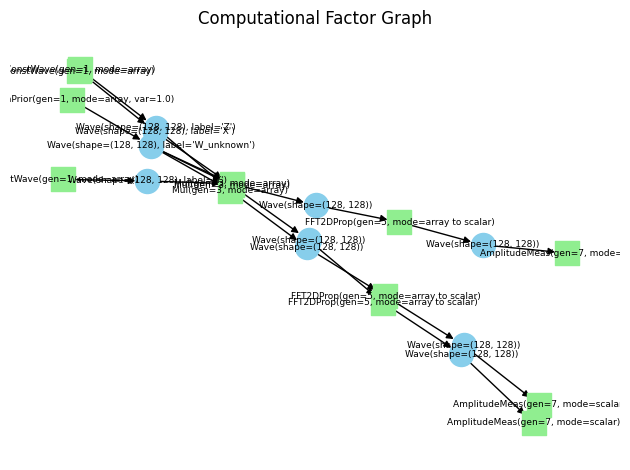

In [9]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

In [10]:
%prun -l 40 -s cumulative g.run(n_iter=100, callback=None, verbose = None)

         196404 function calls in 0.779 seconds

   Ordered by: cumulative time
   List reduced from 125 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.779    0.779 {built-in method builtins.exec}
        1    0.000    0.000    0.779    0.779 <string>:1(<module>)
        1    0.000    0.000    0.779    0.779 graph.py:160(run)
      100    0.002    0.000    0.565    0.006 graph.py:155(backward)
      300    0.001    0.000    0.241    0.001 fft_2d_propagator.py:123(backward)
      100    0.001    0.000    0.214    0.002 graph.py:150(forward)
      300    0.034    0.000    0.195    0.001 fft_2d_propagator.py:70(compute_belief)
      300    0.002    0.000    0.173    0.001 multiply_propagator.py:125(backward)
     1500    0.159    0.000    0.170    0.000 uncertain_array.py:332(__truediv__)
      600    0.073    0.000    0.152    0.000 multiply_propagator.py:85(_compute_backward)
      300    0.001    0